# MNIST TUTORIAL

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/01-mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/01-mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/01-mnist.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table><br><br>

### Connect to EvaDB

In [1]:
%pip install --quiet "evadb[vision,notebook]"
import evadb
cursor = evadb.connect().cursor()

Note: you may need to restart the kernel to use updated packages.


### Download the video and load it into EvaDB

In [2]:
# Getting MNIST as a video
!wget -nc "https://www.dropbox.com/s/yxljxz6zxoqu54v/mnist.mp4"

File ‘mnist.mp4’ already there; not retrieving.



In [3]:
# Load the video into EvaDB
cursor.query("DROP TABLE IF EXISTS MNISTVid").df()
cursor.query("LOAD VIDEO 'mnist.mp4' INTO MNISTVid").df()

,0
0,Number of loaded VIDEO: 1


### Run the Image Classification Function over the video

In [4]:
# Run a query on video data
query = cursor.query("""
    SELECT data, MnistImageClassifier(data).label
    FROM MNISTVid
    WHERE id = 30 OR id = 50 OR id = 70 OR id = 0 OR id = 140
""")
response = query.df()

/Users/jiashenc/Workspace/eva/evadb_venv/lib/python3.11/site-packages/evadb/models/storage/batch.py:271: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_frames = pd.concat(frames, axis=1, copy=False, ignore_index=False).fillna(
/Users/jiashenc/Workspace/eva/evadb_venv/lib/python3.11/site-packages/evadb/models/storage/batch.py:271: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_frames = pd.concat(frames, axis=1, copy=False, ignore_index=False).fillna(


### Visualize output of query on the video

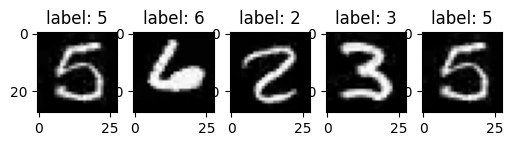

In [5]:
# !pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=[6,8])

for axi in ax.flat:
    idx = np.random.randint(len(response))
    img = response['mnistvid.data'].iloc[idx]
    label = response['mnistimageclassifier.label'].iloc[idx]
    axi.imshow(img)
    
    axi.set_title(f'label: {label}')

plt.show()

### Drop the function if needed

In [6]:
cursor.query("DROP FUNCTION MnistImageClassifier").df()

UnexpectedToken: Unexpected token Token('ID', 'FUNCTION') at line 1, column 6.
Expected one of: 
	* TABLE
	* DATABASE
	* INDEX
	* UDF
Previous tokens: [Token('DROP', 'DROP')]
